# Imports

In [82]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

%matplotlib inline
set_seed = torch.manual_seed(0)

# Data generator

In [199]:
def regression_data_generator(n, w = torch.tensor([10.0])):
    '''
    n is the number of samples per minibatch
    k is the dimensionality of each vector x
    '''
    x = torch.rand(size=(n, w.shape[0])) #x is nxk
    w = w       #parameter initialization
    y = x@w
    y = torch.normal(mean=y, std=0.01)      #a pinch of gaussian noise

    return x, y

In [162]:
def random_data_pertubator(y, p = 0.1):
    '''
    It perturbs each entry of a matrix with p = 0.1.
    The perturbation consists of a multiplication by a random number between 0 and 1000.
    '''
    mask = torch.bernoulli(p*torch.ones_like(y))      # torch.bernoulli accepts an input matrix and does a trial for each entry
    mask = mask.type(torch.int64)           # torch.bernoulli returns floats, but masks cannot
    y[mask == 1] *= torch.rand(size=(1,)).item()*1000

    return y

# Model


In [84]:
class Regression_model:
    def __init__(self, k = 2, sigma = 0.01):
        self.W = torch.normal(mean=0,
                              std=sigma,
                              size=(k,),            # writing (k, ) makes it possible to have a 1-tuple
                              requires_grad=True)
        self.b = torch.zeros(size=(1,), requires_grad=True)
        
    def forward(self, x):
        return x@(self.W.reshape((x.shape[-1], 1))) + self.b

# Loss

## L2 loss

In [106]:
def l2_loss(y, y_hat):
    '''
    Remember that y (true value) and y_hat (prediction) are nx1
    '''
    
    l = (y_hat-torch.reshape(y, y_hat.shape)) ** 2 / 2
    return l.mean()

## Absolute value loss

In [107]:
def abs_loss(y, y_hat):
    '''
    Remember that y (true value) and y_hat (prediction) are nx1
    '''
    
    l = (y_hat-torch.reshape(y, y_hat.shape)).abs()
    return l.sum()

# Optimizer

In [180]:
class SGD:
    def __init__(self, parameters, lr = 0.01, max_grad = None):
        self.lr = lr
        self.parameters = parameters
        self.max_grad = max_grad

    def step(self):
        for p in self.parameters:
            # The atrocity in the second condition of the if statement creates a matrix with entry max_grad and
            # dimension p.grad.shape, compares them, and returns true if any value of p.grad is bigger than
            # any value of max_grad.
            # TL;DR
            # If any gradient is over max_grad, there is no backpropagation
            if self.max_grad and torch.any(torch.tensor([self.max_grad]*p.grad.shape[0]).reshape_as(p.grad) < p.grad):
                continue
            else:
                p -= self.lr * p.grad

    def zero_grad(self):
        for p in self.parameters:
            if p.grad is not None:
                p.grad.zero_()

# Trainer

In [87]:
class Trainer:
    def __init__(self, model, loss, optimizer, iterations = 20, epochs = 5):
        self.model = model
        self.loss = loss
        self.optimizer = optimizer
        self.iterations = iterations
        self.epochs = epochs

    def live_plot(self, x, y, figsize=(7,5), title=''):
        '''
        It plots only the average loss per epoch.
        '''
        clear_output(wait=True)         # This is needed for live updates
        plt.figure(figsize=figsize)
        x = x.astype('float64')
        y= y.astype('float64')
        
        if len(x) > 1:
            plt.scatter(x,y, label='axis y', color='k') 

        plt.title(title)
        plt.grid(True)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()
        
    def fit_model(self, generated_data):
        '''
        A function that creates the training data,
        optimizes the model and plots the results.
        '''
        x, y = generated_data
        train_loss = np.array([])

        for i in range(self.epochs):
            y_hat = self.model.forward(x)
            loss = self.loss(y, y_hat)
            train_loss = np.append(train_loss, loss.item())   # this is needed for plotting

            self.optimizer.zero_grad()
            with torch.no_grad():
                loss.backward()
                self.optimizer.step()

            # Updating the training plot
            self.live_plot(np.arange(i+1), train_loss, title="Training loss")        

# Training tests


## Normal training

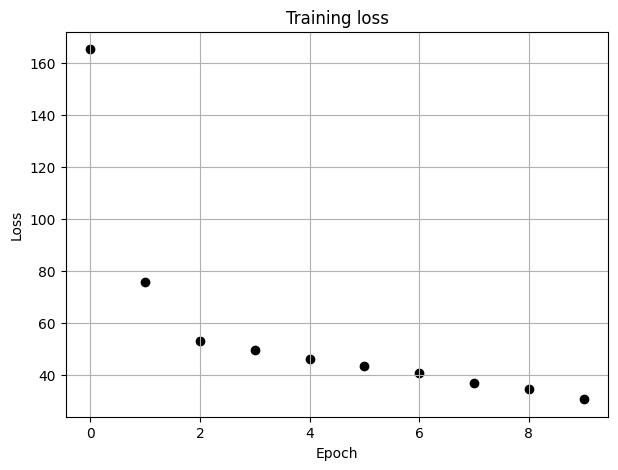

In [113]:
generated_data = regression_data_generator(n = 30, w = torch.tensor([10.0, 0]))
model = Regression_model(k = generated_data[0].shape[1], sigma=0.01)
optimizer = SGD([model.W, model.b], lr=0.08)
trainer = Trainer(model, abs_loss, optimizer, epochs=10)

trainer.fit_model(generated_data)

### Real line vs Fitted line

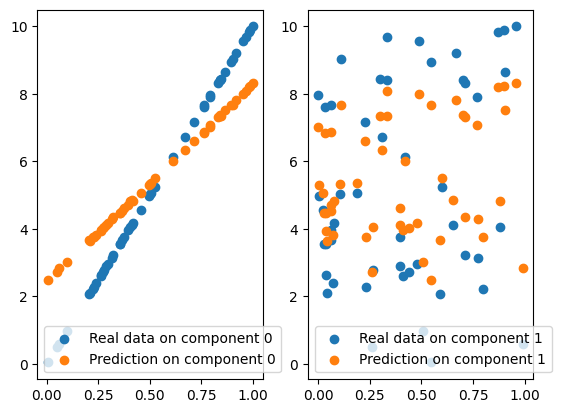

In [114]:
x, y = regression_data_generator(50, w = torch.tensor([10.0, 0]))
y_hat = model.forward(x)

# Matplotlib only supports numpy
x = x.detach().numpy()
y = y.detach().numpy()
y_hat = y_hat.detach().numpy()

# Let's plot singularly every component of x
fig, ax = plt.subplots(nrows = 1, ncols = 2)

for i in range(x.shape[1]):
    ax[i].scatter(x[:, i], y, label=f"Real data on component {i}")
    ax[i].scatter(x[:, i], y_hat, label=f"Prediction on component {i}")
    ax[i].legend()

plt.show()

## Perturbed training

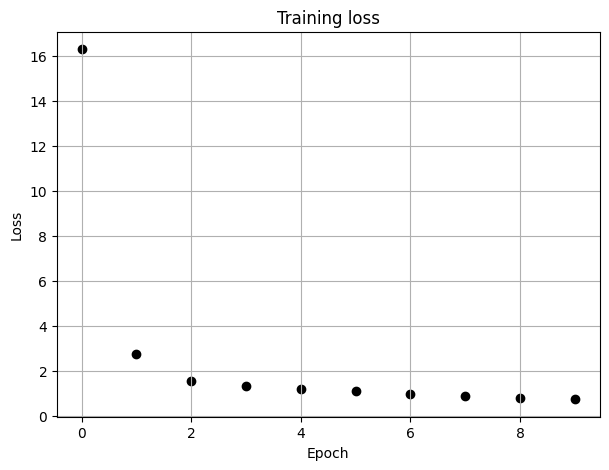

In [197]:
generated_data = regression_data_generator(n = 30, w = torch.tensor([10.0]))
#generated_data = (generated_data[0], random_data_pertubator(generated_data[1])) # perturbation step

model = Regression_model(k = generated_data[0].shape[1], sigma=0.01)
optimizer = SGD([model.W, model.b], lr=1, max_grad=100)
trainer = Trainer(model, l2_loss, optimizer, epochs=10)

trainer.fit_model(generated_data)

### Real line vs Fitted line

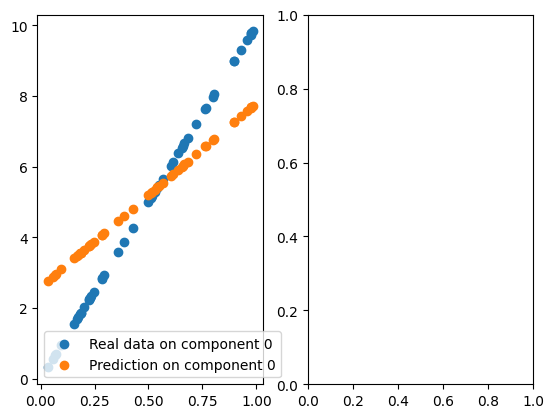

In [198]:
x, y = regression_data_generator(50, w = torch.tensor([10.0]))
y_hat = model.forward(x)

# Matplotlib only supports numpy
x = x.detach().numpy()
y = y.detach().numpy()
y_hat = y_hat.detach().numpy()

# Let's plot singularly every component of x
fig, ax = plt.subplots(nrows = 1, ncols = 2)

for i in range(x.shape[1]):
    ax[i].scatter(x[:, i], y, label=f"Real data on component {i}")
    ax[i].scatter(x[:, i], y_hat, label=f"Prediction on component {i}")
    ax[i].legend()

plt.show()